<a href="https://colab.research.google.com/github/TobyChen320/DS-Unit-2-Kaggle-Challenge/blob/master/Toby_Chen_DSPT6_Kaggle_Competition_1_3_4_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

else:
    DATA_PATH = '../data/'

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    X = X.copy()
    
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 'num_private', 'amount_tsh', 'gps_height', 'population']
    
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
target = 'status_group'
train_features = train.drop(columns=[target])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()
features = numeric_features + categorical_features

In [0]:
X_train=train[features]
y_train=train[target]
X_val=val[features]
y_val=val[target]
X_test=test[features]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((47520, 40), (47520,), (11880, 40), (11880,), (14358, 40))

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(random_state=42)
)

param_distributions = {
    'randomforestclassifier__n_estimators': range(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
    'randomforestclassifier__min_samples_leaf': [1, 10, 100], 
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  5.0min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.9min finished


In [0]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation Accuracy', search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.5893839365719267, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 276}
Cross-validation Accuracy 0.7988846801346802


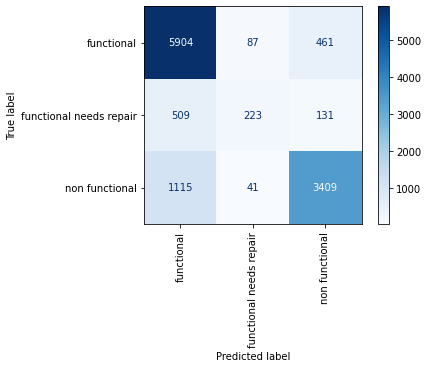

In [0]:
plot_confusion_matrix(search, X_val, y_val,
                      values_format='.0f', xticks_rotation='vertical', cmap='Blues')

In [0]:
# search.predict(X_test)
# y_pred = search.predict(X_test)
# submission = sample_submission.copy()
# submission['status_group'] = y_pred
# submission.to_csv('submission-06.csv', index=False)